<a href="https://colab.research.google.com/github/1eetnals/Body-Morphometry-kidney-and-tumor/blob/main/unetr_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
'''

'\n!pip install -q "monai-weekly[nibabel, tqdm, einops]"\n!python -c "import matplotlib" || pip install -q matplotlib\n%matplotlib inline\n'

In [ ]:
!nvidia-smi # check GPU mem

Sun Aug 29 16:53:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0 Off |                  N/A |
| 36%   27C    P8    20W / 350W |   3925MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
# !pip install monai
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    MapTransform,
    ResizeWithPadOrCropd,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.7.dev2134
Numpy version: 1.20.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b5a2e745f93752d1dec38c6c138993c6dddd85da

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
root_dir='./pth_file/'

In [ ]:
train_path = '/nfs/hufsbme/moai2021/data/train/NIFTI/'
Input_folder = os.listdir(train_path)
train_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].startswith('nifti'):
        data_file=os.listdir(train_path+Input_folder[i])
        for j in range(0,len(data_file)):
            if data_file[j].endswith('.nii.gz'):
                train_files.append(train_path+Input_folder[i]+'/'+data_file[j])

train_files.sort()
train_files

['/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training001/ct_training001.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training002/ct_training002.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training003/ct_training003.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training004/ct_training004.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training005/ct_training005.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training006/ct_training006.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training007/ct_training007.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training008/ct_training008.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training009/ct_training009.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training010/ct_training010.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training011/ct_training011.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training012/ct_training012.nii.gz',
 '/n

In [ ]:
train_label_path = '/nfs/hufsbme/moai2021/data/train/Label_NIFTI'
Input_folder = os.listdir(train_label_path)
train_label_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].startswith('training'):
        train_label_files.append(train_label_path+'/'+Input_folder[i])

train_label_files.sort()
train_label_files

['/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training001.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training002.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training003.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training004.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training005.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training006.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training007.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training008.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training009.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training010.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training011.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training012.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training013.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training014.nii.gz',
 '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/t

In [ ]:
train_ind=np.arange(0,50)
data_dicts=[
    {
        "image": train_files[idx],
        "label": train_label_files[idx],
    }
    for idx in train_ind
]

train_f=data_dicts
len(train_f)
train_f

[{'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training001/ct_training001.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training001.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training002/ct_training002.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training002.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training003/ct_training003.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training003.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training004/ct_training004.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training004.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training005/ct_training005.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training005.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training006/ct_training006.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/La

In [ ]:
val_ind=np.arange(50,70)
data_dicts=[
    {
       "image": train_files[idx],
        "label": train_label_files[idx],
    }
    for idx in val_ind
]

val_f=data_dicts
len(val_f)
val_f

[{'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training051/ct_training051.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training051.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training052/ct_training052.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training052.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training053/ct_training053.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training053.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training054/ct_training054.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training054.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training055/ct_training055.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/Label_NIFTI/training055.nii.gz'},
 {'image': '/nfs/hufsbme/moai2021/data/train/NIFTI/nifti_training056/ct_training056.nii.gz',
  'label': '/nfs/hufsbme/moai2021/data/train/La

In [ ]:
'''class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) ==0)
            result.append(d[key].astype(np.int8) == 1)
            result.append(d[key].astype(np.int8) == 2)
#            result.append(d[key].astype(np.int8) == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d'''

'class ConvertToMultiChannel(MapTransform):\n    """\n    Convert labels to multi channels:\n    """\n    def __call__(self, data):\n        d = dict(data)\n        for key in self.keys:\n            result = []\n            result.append(d[key].astype(np.int8) ==0)\n            result.append(d[key].astype(np.int8) == 1)\n            result.append(d[key].astype(np.int8) == 2)\n#            result.append(d[key].astype(np.int8) == 4)\n            d[key] = np.stack(result, axis=0).astype(np.float32)\n        return d'

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        #ConvertToMultiChannel(keys=["label"]), 
        #Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(1.5, 1.5, 2.0),
        #    mode=("bilinear", "nearest"),
        #),
        #ResizeWithPadOrCropd(
        #    keys=["image", "label"],
        #    spatial_size=(512,512,64),
        #),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-285,
            a_max=350,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        #ConvertToMultiChannel(keys=["label"]), 
        #Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(1.5, 1.5, 2.0),
        #    mode=("bilinear", "nearest"),
        #),
        #ResizeWithPadOrCropd(
        #    keys=["image", "label"],
        #    spatial_size=(512,512,64),
        #),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-200, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
from monai.transforms import LoadImage
from monai.data.image_reader import (
    ITKReader,
    NumpyReader,
    PILReader,
    NibabelReader,
)

#for i in range(len(train_f)):
for i in range(0,3):
    data, meta = LoadImage()(train_f[i]['image'])
    label,label_meta=LoadImage()(train_f[i]['label'])
    print(f"image data shape:{data.shape}")
    print(f"label data shape:{label.shape}")
    #print(f"meta data:{meta}")
    print('####')

image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####


In [ ]:
from monai.transforms import LoadImage

label,label_meta=LoadImage()(train_f[0]['label'])
np.count_nonzero( label== 1)

438818

In [ ]:
train_ds = CacheDataset(
    data=train_f,
    transform=train_transforms,
    cache_num=50, #
    cache_rate=1.0,
    num_workers=0,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=True
)

val_ds = CacheDataset(
    data=val_f, transform=val_transforms, cache_num=20, cache_rate=1.0, num_workers=0
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

Loading dataset: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


label number?

In [ ]:
print(val_ds[0]["image_meta_dict"])

{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(1, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  3, 512, 512,  64,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(4, dtype=int16), 'bitpix': array(16, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=float32), 'scl_inter': array(nan, dtype=float32), 'slice_end': array(0, dtype=int16), 'slice_code': array(0, dtype=uint8), 'xyzt_units': array(10, dtype=uint8), 'cal_max': array(0., dtype=float32), 'cal_min': array(0., dtype=float32), 'slice_duration': array(0., dtype=float32), 'toffset': array(0., dtype=float32), 'glmax': array(0, dtype=int32), 'glmin': array(0, dtype=int32), 'qfo

image shape: torch.Size([1, 460, 460, 64]), label shape: torch.Size([1, 460, 460, 64])


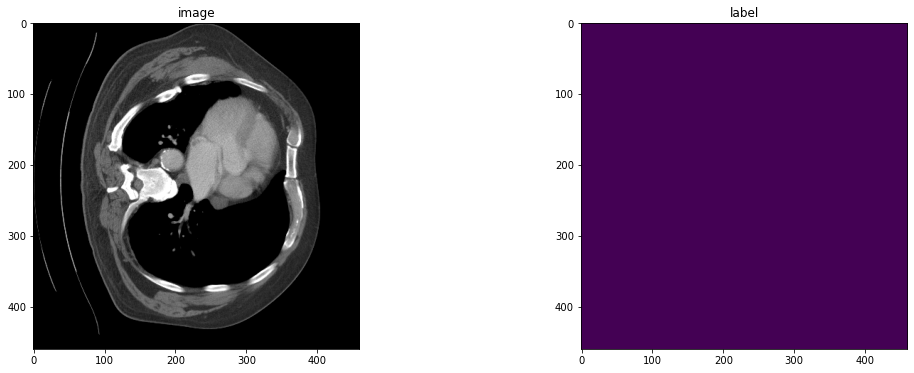

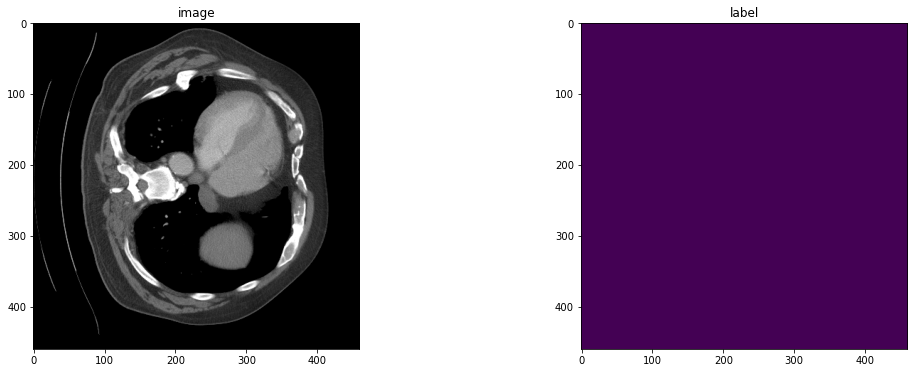

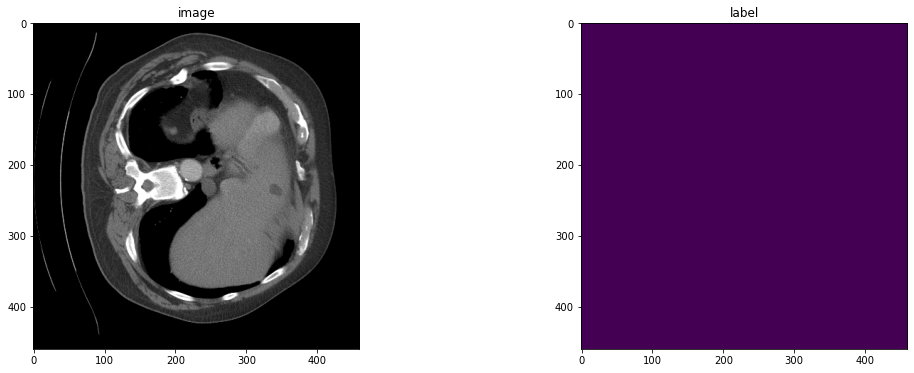

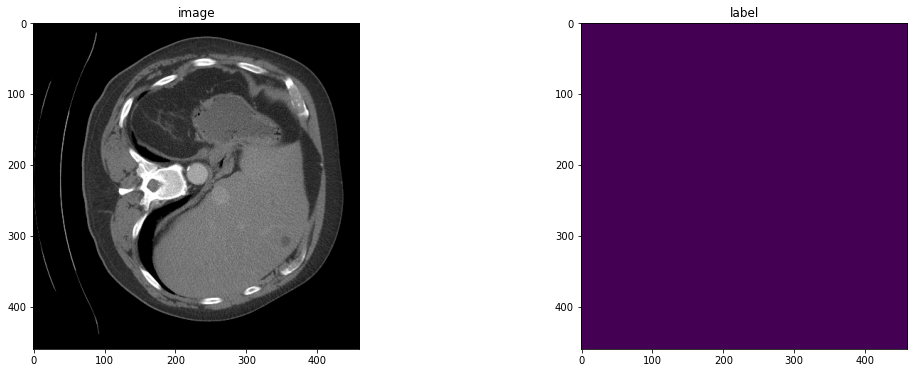

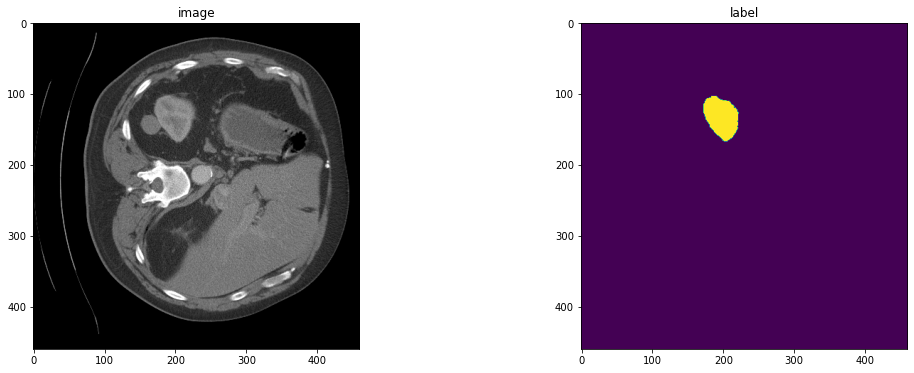

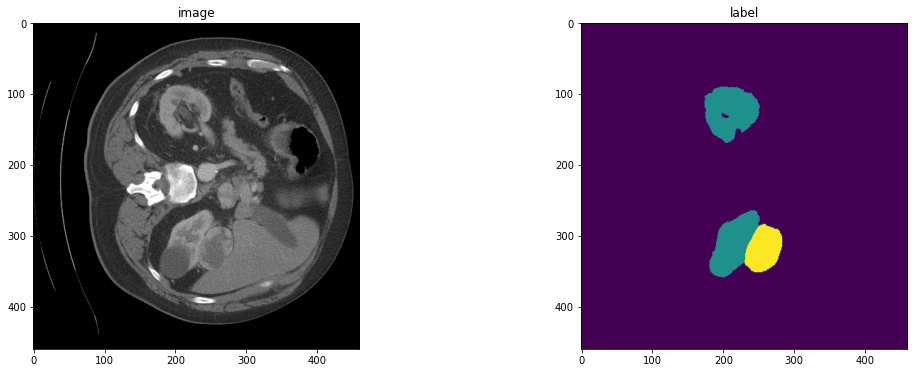

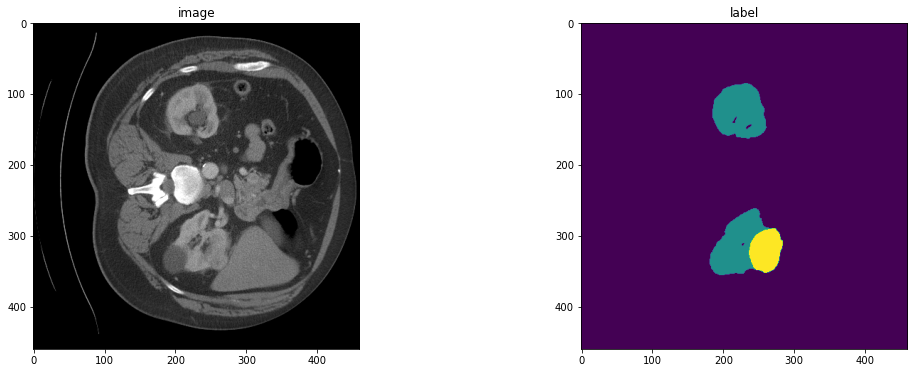

In [ ]:
case_num = 1
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
for i in range(0,7):
  plt.figure("image", (18, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(img[0, :, :, i*5].detach().cpu(), cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[0, :, :, i*5].detach().cpu())
  plt.show()

In [ ]:
for val_image in val_loader:
  print(val_image['image'].shape)

torch.Size([1, 1, 512, 458, 64])
torch.Size([1, 1, 460, 460, 64])
torch.Size([1, 1, 498, 379, 64])
torch.Size([1, 1, 506, 443, 64])
torch.Size([1, 1, 476, 387, 64])
torch.Size([1, 1, 486, 419, 64])
torch.Size([1, 1, 512, 395, 64])
torch.Size([1, 1, 497, 409, 64])
torch.Size([1, 1, 500, 408, 64])
torch.Size([1, 1, 512, 464, 64])
torch.Size([1, 1, 512, 454, 64])
torch.Size([1, 1, 512, 455, 64])
torch.Size([1, 1, 512, 382, 64])
torch.Size([1, 1, 512, 434, 64])
torch.Size([1, 1, 512, 386, 64])
torch.Size([1, 1, 512, 441, 64])
torch.Size([1, 1, 512, 477, 64])
torch.Size([1, 1, 512, 468, 64])
torch.Size([1, 1, 488, 383, 64])
torch.Size([1, 1, 512, 410, 64])


torch.Size([4, 1, 96, 96, 32])


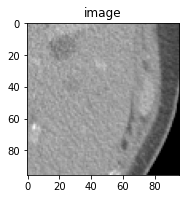

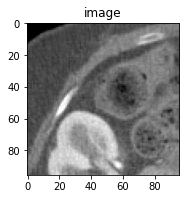

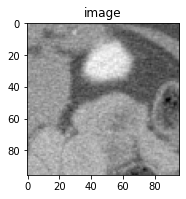

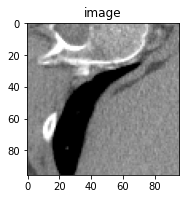

torch.Size([4, 1, 96, 96, 32])


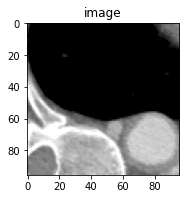

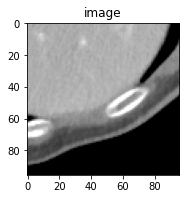

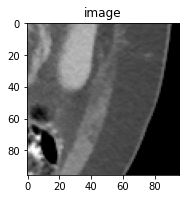

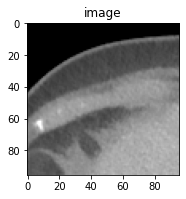

torch.Size([4, 1, 96, 96, 32])


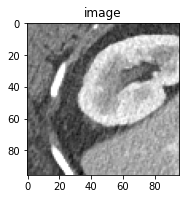

In [ ]:
j=0
for train_image in train_loader:
  print(train_image['image'].shape)
  for i in range(4):
    image=train_image['image'][i]
    plt.figure("check", (6,6))
    plt.subplot(1,2,1)
    plt.title("image")
    plt.imshow(image[0,:,:,0], cmap="gray")
    plt.show()
  j+=1
  if j==3:
    break

In [ ]:
device = torch.device("cuda:0")
!nvidia-smi

In [ ]:
#pip install einops['module']
#!pip uninstall einops
#!pip install "einops==0.2.0"

In [ ]:
!pip install einops
import einops

In [ ]:
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, reduce

model = UNETR(
    in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=64, #16
    hidden_size=384, #768
    mlp_dim = 1536, #3072
    num_heads=12, #12
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-4, weight_decay=1e-5
    max_iterations = 50
    eval_num = 5
    train completed, best_metric: 0.0086 at iteration: 5
    //
        in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-5, weight_decay=1e-5
    max_iterations = 200
eval_num = 10
train completed, best_metric: 0.3352 at iteration: 200

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 32), 2, model) #4
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "0829_best_metric_model.pth") # change!!!!!!!!!!!!!!!!!!!!!
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 10000
eval_num = 50 #500
post_label = AsDiscrete(to_onehot=True, n_classes=3)
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "0829_best_metric_model.pth"))) # change!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
case_num = 1
model.load_state_dict(torch.load(os.path.join(root_dir, "0829_best_metric_model.pth"))) # change!!!!!!!!!!!!!!!!!
model.eval()
with torch.no_grad():
    #img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 32), 2, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 16], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 16])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :,16]
    )
    plt.show()